# Module 3 - Web APIs

# Table of Contents
- [Introduction](#Introduction)

    - [Learning Objectives](#Learning-Objectives)
    - [Topics](#Topics)

- [Setup - Load Python packages](#Setup---Load-Python-packages)
- [Using APIs](#Using-APIs)
    * [RESTful APIs](#RESTful-APIs)
    * [OTP description](#OpenTripPlanner)
    * [Index API](#Index-API)
    * [JSON](#JSON)
    * [API Documentation](#API-Documentation)
    * [Python Dictionary](#Python-Dictionary)
    * [Routing API](#Routing-API)
        * [Scraping Useful Chicago Data](#Scraping-Useful-Chicago-Data)
        * [Geocoding](#Geocoding)
        * [Planner Resource Syntax](#Planner-Resource-Syntax)
        * [Incorporating Databases](#Incorporating-Databases)
    * [Isochrone API](#Isochrone-API)

# Introduction

- Back to [Table of Contents](#Table-of-Contents)

In this module, we introduce two general ways that one can retrieve data from data sources on the Internet: APIs and web scraping. We've already covered web scraping, and given the messiness of that subject you may find yourself really appreciating the relative simplicity of using APIs - once you grasp the concepts.

API stands for "Application Programming Interface". An API is an agreed upon way for one computer program to interact with another computer program.  There are many different kinds of APIs.  Some facilitate interaction between computers over the Internet, some do not. In fact, the Python module SQL Alchemy that we used yesterday is a type of API for talking to databases - you'll see more on APIs for databases with SQL Alchemy later in this course.

For this session, we focus on web APIs over HTTP that let a user query and retrieve data over the Internet.  This type of API documents an agreed-upon structure and content of requests and responses a program can use to interact with a system.  As long as your code adheres to a system's API, it should be able to reliabily request and receive data from the system.

Below, we show how to make network API requests using HTTP(S).

## Learning Objectives

- Back to [Table of Contents](#Table-of-Contents)

** Learning objectives:**

- **Become familiar with different types of APIs.** Includes GET- and POST- based HTTP APIs, different formats of request bodies for POST-based APIs (form inputs, arbitrary JSON and XML, and then formalized dialects of each like SOAP), and how to learn a given API.
- **Learn the tools used to interact with network-based APIs.** Understand the tools for talking directly with APIs over HTTP connection, introduce libraries that abstract the details of the API and present a simplified programmatic interface, and then understand how to choose a tool.

## Topics

- Back to [Table of Contents](#Table-of-Contents)

Outline of topics covered in this notebook:

- Making raw HTTP API requests
- Using pre-packaged API client libraries
- Practical considerations - Knowing API rules and coding to follow them, and performance
- Example: OpenTripPlanner

# Setup - Load Python packages

- back to [Table of Contents](#Table-of-Contents)

In [1]:
## import Python packages ##
import time # to convert time as needed and report how long some functions take

# interacting with websites and web-APIs
import requests # easy way to interact with web sites and services
import json # read/write JavaScript Object Notation (JSON)
from bs4 import BeautifulSoup

# data manipulation
import pandas as pd # easy data manipulation
import geopandas as gpd # geographic data manipulation
# from geopandas.tools import sjoin, overlay # spatial join and overlay functions
from shapely.geometry import Point, LineString # to create lines from a list of points

# visualization
import matplotlib as mplib
import matplotlib.pyplot as plt # visualization package

# so images get plotted in the notebook
%matplotlib inline

In [2]:
print("Package versions")
print("requests: {}".format(requests.__version__))
print("json: {}".format(json.__version__))
print("pandas: {}".format(pd.__version__))
print("geopandas: {}".format(gpd.__version__)) # check that correct version of geopandas is installed, should be v0.2+
print("matplotlib: {}".format(mplib.__version__))

Package versions
requests: 2.13.0
json: 2.0.9
pandas: 0.19.2
geopandas: 0.3.0
matplotlib: 2.0.0


# Using APIs

- Back to the [Table of Contents](#Table-of-Contents)

API overview
+ In general: APIs ([Application Programming Interfaces](https://en.wikipedia.org/wiki/Application_programming_interface)) are "set[s] of subroutine definitions, protocols, and tools for building software and applications. A good API makes it easier to develop a program by providing all the building blocks, which are then put together by the programmer."
+ Here we're looking at a **web-API**, a specific type of API which makes it easier to interact with some aspect of a website. In this course, we'll be using APIs to gether data in an automated way - like grabbing a bunch of prior tweets from Twitter. More generally, APIs can also be used to interact with websites in any way the API is designed to. For instance, you can post and delete tweets with Twitter's API, too.

## Geocoding

- Back to the [Table of Contents](#Table-of-Contents)

We have scraped addresses, but OTP works best with latitude and longitude coordinates. We can use the [geocoder module](https://pypi.python.org/pypi/geocoder) to get latitude and longitude exactly just from the organization addresses. Note this is a combination of great tools - a simple Python module (`geocoder`) interacting with Google's wonderful geocoding API. The code below would work out in the wild, but since we are working in a restricted environment, we can't get to the Google API.

The geocoder module can speak to a wide range of external services, including ArcGIS, Bing, MapBox, OpenStreetMaps, and many others, in addition to Google. The API lets you geocode (addresses to latitue and longitude), reverse geocode (latitude and longitude to addresses), as well as get timezones and elevations on locations.

### Google geocoder API

Use [Google API](https://developers.google.com/maps/documentation/geocoding/intro) to geocode service locations

In [3]:
centers_df = pd.read_csv('./data/chicago-workforce-centers.csv')
centers_df.head()

,Unnamed: 0,address,center_name,phone_number
0,0,5957 W 87th St. Oak Lawn IL 60453,A.E.R.O. Special Education,(708) 499-0181
1,1,6707 North Ave. Oak Park IL 60302,African American Christian Foundation,(708) 848-1700
2,2,1945 W Wilson Chicago IL 60640,Albany Park Community Center,(773) 539-3828
3,3,1807 W Sunnyside Suite 1D Chicago IL 60640,Alternative Schools Network,(773) 728-4030
4,4,723 W Algonquin Arlington Heights IL 60005,Arlington Heights Workforce CenterBusiness & C...,(847) 981-7400


In [4]:
centers_df.shape

(55, 4)

In [5]:
import geocoder

lat = []
lon = []

for add in centers_df["address"]:
    g = geocoder.google(add)
    
    if g.status == 'OK':
        lon.append(g.latlng[1])
        lat.append(g.latlng[0])
    else:
        print('No result or over query limit for {}, adding empty value as placeholder'.format(add))
        lon.append(None)
        lat.append(None)


No result or over query limit for 6707 North Ave. Oak Park IL 60302, adding empty value as placeholder
No result or over query limit for 1945 W Wilson Chicago IL 60640, adding empty value as placeholder
No result or over query limit for 1250 Portland Ave.Chicago Heights IL 60411, adding empty value as placeholder
No result or over query limit for 3400 S Emerald St. Chicago IL 60616; 2102 W Monroe  Chicago IL 60612;  9600 S Vincennes Chicago IL 60643, adding empty value as placeholder
No result or over query limit for 1000 E. 111th St. 10th Floor Chicago IL 60628, adding empty value as placeholder
No result or over query limit for 130 E. Randolph Ste. 2600 Chicago IL 60601, adding empty value as placeholder
No result or over query limit for Prairie State CollegeATOC Building202 S. Halsted, Suite 148Chicago Heights, IL 60411, adding empty value as placeholder
No result or over query limit for 1347 W Erie Chicago IL 60642, adding empty value as placeholder
No result or over query limit fo

In [6]:
# add results to our data frame

centers_df["latitude"] = pd.Series(lat)
centers_df["longitude"] = pd.Series(lon)

In [7]:
# optional hardcoded values if needed

# lat = [41.733737,
#             41.9087846,
#             41.9647695,
#             41.9631174,
#             42.0457523,
#             41.9697109,
#             41.9252578,
#             41.4824241,
#             41.5081785,
#             41.8322347,
#             41.6944193,
#             41.8444394,
#             41.8849173,
#             41.5255653,
#             41.8543913,
#             41.8511856,
#             41.8931701,
#             41.8804296,
#             41.8905965,
#             42.0076194,
#             41.9647485,
#             41.8457521,
#             41.8409604,
#             41.9589605]

# lon = [-87.770246,
#              -87.7931388,
#              -87.6786497,
#              -87.6748518,
#              -87.9922059,
#              -87.6598793,
#              -87.7008122,
#              -87.6782855,
#              -87.6234975,
#              -87.5990999,
#              -87.5990999,
#              -87.7236882,
#              -87.6231249,
#              -87.6386009,
#              -87.6355797,
#              -87.7775432,
#              -87.6614166,
#              -87.7066519,
#              -87.702801,
#              -87.6689743,
#              -87.6570292,
#              -87.6858569,
#              -87.6862319,
#              -87.6747326]

In [8]:
# if use hardcoded:
# centers_lim = centers_df[0:24]
# centers_lim["latitude"] = pd.Series(lat)
# centers_lim["longitude"] = pd.Series(lon)

# if use geocoded values
centers_lim = centers_df[~centers_df['latitude'].isnull()]
print(centers_lim.shape)
centers_lim.head()

(27, 6)


,Unnamed: 0,address,center_name,phone_number,latitude,longitude
0,0,5957 W 87th St. Oak Lawn IL 60453,A.E.R.O. Special Education,(708) 499-0181,41.733737,-87.770246
3,3,1807 W Sunnyside Suite 1D Chicago IL 60640,Alternative Schools Network,(773) 728-4030,41.963117,-87.674852
4,4,723 W Algonquin Arlington Heights IL 60005,Arlington Heights Workforce CenterBusiness & C...,(847) 981-7400,42.045752,-87.992206
5,5,4820 N Broadway 3rd Floor Chicago IL 60640,Asian Human Services,(773) 293-8119,41.969711,-87.659879
6,6,2415 N. Milwaukee Chicago IL 60647,Aspira,(773) 770-1940,41.925258,-87.700812



#### OpenTripPlanner
[OpenTripPlanner (OTP)](http://docs.opentripplanner.org/en/latest/) is an open source routing software that provides a number of services, here we'll explore:
1. [Index API](#Index-API) - provides information about the data loaded into OTP, for instance what transportation agencies' data are included;
2. [Routing API](#Routing-API) - creates a plan for how to get from one location to another, with a number of additional options such as:
  * Departure time (and date) - if you're curious about a specific departure time or date;
  * transit modes - default is to consider any public transportation option in the system, but it can also be set to "AUTO" to do vehicle routing or "WALK" for walking only directions.
  
3. [Isochrone API](#Isochrone-API) - generates a polygon representing the area a traveler can reach if they start from a given location and travel for a specified amount of time (isochrone means 'equal time').

Data:
+ OpenStreetMap (OSM) for [Chicago from Mapzen's Metro Extracts](https://mapzen.com/data/metro-extracts/metro/chicago_illinois/)
+ General Transit Feed Specification (GTFS) for [Chicago from transit.land](https://transit.land/feed-registry/?metro=Chicago)

If we "build a graph" locally we can go to our browser here (http://localhost:8080/) and see what we have.

## RESTful APIs

- Back to the [Table of Contents](#Table-of-Contents)

The OTP APIs are what is called "[RESTful](https://en.wikipedia.org/wiki/Representational_state_transfer)" web services. REST stands for REpresentational State Transfer, but don't worry about the acronym so much as the idea. RESTful services adhere to a [series of requirements](https://www.restapitutorial/whatisrest.html) that enable them to be consistent, scalable, reliable, and relatively simple. RESTful APIs allow you to access a pre-defined set of operations through HTTP(S) requests. REST is fantastic because, in part, if you can generate the right URL, you'll always get the right response (this was not always the case with SOAP - the predecessor to REST).

To use a RESTful API, we'll need to understand (1) how to properly format the request and (2) how to manage and make use of the response from the API. Below we will walk through these concepts while using some of OTP's web services.

In [9]:
### First, we need to set a few parameters. ###

# base URL where OTP is installed
base_url = "http://localhost:8080/otp/routers/"

In [10]:
# Router ID - 
# OTP could have many different routers available for different cities or subsets of transportation agencies.
# in this example we only have one, unnamed router for Chicago
routerID = 'default/' # 

# update base_url to include router name
base_url += routerID
print(base_url)

http://localhost:8080/otp/routers/default/


### Index API

- Back to the [Table of Contents](#Table-of-Contents)

The Index API provides access to general information about the data loaded into a given OTP router (as specified by the 'routerID' variable set above). Full list of [options are here](http://dev.opentripplanner.org/apidoc/1.0.0/resource_IndexAPI.html).

Below, we can make a request simply by taking our base URL and adding the `feeds` endpoint. Here, we use the term endpoint to refer to the completed URL that links to the most granular aspect of an API. The combination of the router id, index API, and feeds request make up our endpoint. This will provide a list of data feeds available for the router we've selected.

In [11]:
# Set up query URL
qry_url = '{}index/feeds'.format(base_url)

# Again, since we are still using HTTP, we can use the requests package's get 
response = requests.get(qry_url)

# Convert response to text
response = response.text

# Our response is a JSON array:
print(response)

["1","2","3"]


## JSON

- Back to the [Table of Contents](#Table-of-Contents)

[JSON](www.json.org) is a common non-tabular data format often used by services and software on the internet. We'll introduce JSON slowly, but it's helpful to know that it is oriented around the idea of `key-value` pairs. The `keys` refer to information about the data while the `values` is the data itself. For instance, if you were to translate a tabular dataset into JSON, the column names (and possibly row names/numbers) would become `keys`, while the data in the cells would become `values`. Our first JSON response is a simple array, the equivalent of a Python list.

In [12]:
# Convert text to a Python object using the 'json' package
feeds = json.loads(response)

# And now we have a Python list:
print(type(feeds))
print(feeds)

<class 'list'>
['1', '2', '3']


This is just a list of feed IDs created by OTP - so there are three agencies providing data feeds to our version of the OTP. This is not particularly informative, but we did get a response from the web API. Let's check the 'agencies' endpoint to see what more it provides.

In [13]:
## We can use the /agences resource of the Index API to get more information.
## Below, we combine the previous steps into one line and ask for the agency associated with the first feed:
print('{}index/agencies/{}'.format(base_url, '1')) 
print(json.loads(requests.get('{}index/agencies/{}'.format(base_url, '1')).text))

http://localhost:8080/otp/routers/default/index/agencies/1
[{'id': '1', 'name': 'Chicago Transit Authority', 'url': 'http://transitchicago.com', 'timezone': 'America/Chicago', 'lang': 'en', 'phone': '1-888-YOURCTA', 'fareUrl': 'http://www.transitchicago.com/travel_information/fares/default.aspx'}]


This is more helpful - we now know the agency associated with the feed id, as well as its website and other information. Let's use a loop to repeat this for the other feeds.

In [14]:
## Let's do the same for each feed:
for feed in feeds:

    # print out which feed we're looking at on this pass of the loop
    print("feed {}".format(feed))
    
    # get agency information for this feed just as we did above, but using the feed from our list of feeds
    agency = json.loads(requests.get('{}index/agencies/{}'.format(base_url, feed)).text)
    
    print(agency)
        
    # add a blank line after each feed for legibility
    print('')


feed 1
[{'id': '1', 'name': 'Chicago Transit Authority', 'url': 'http://transitchicago.com', 'timezone': 'America/Chicago', 'lang': 'en', 'phone': '1-888-YOURCTA', 'fareUrl': 'http://www.transitchicago.com/travel_information/fares/default.aspx'}]

feed 2
[{'id': 'METRA', 'name': 'Metra', 'url': 'http://www.metrarail.com/', 'timezone': 'America/Chicago', 'lang': 'EN'}]

feed 3
[{'id': 'PACE', 'name': 'PACE', 'url': 'http://www.pacebus.com', 'timezone': 'America/Chicago', 'lang': 'en'}]



### API Documentation

- Back to the [Table of Contents](#Table-of-Contents)

If you want more information about what routes are included in a given feed, you can query the 'routes' resources as below. At this point, you may be wondering how you would know what resources and endpoints are available for a given API. This is where API documentation comes in. The [OpenTripPlanner Index API documentation](dev.opentripplanner.org/apidoc/0.20.0/resource_indexAPI.html) includes a list of valid HTTP methods (mostly get and a few post) for the resources and specific endpoints within the Index API.

For instance, there is a valid HTTP get request for the URL `/routers/{routerid}/index/agencies/{feedId}` where routerid and feedId are changeable parameters. This is how you would have known that the above requests would be successful.

Below, we can examine all the routes of one agency in the format: `/routers/{router_id}/index/agencies/{feedID}/{agencyID}/routes`

In [15]:
# Using agency 'METRA' from first feed
routes = json.loads(requests.get('{0}index/agencies/{1}/{2}/routes'.format(base_url, '1', '1')).text)
print(routes)

[{'id': '1:1', 'shortName': '1', 'longName': 'Bronzeville/Union Station', 'mode': 'BUS', 'agencyName': 'Chicago Transit Authority'}, {'id': '1:121', 'shortName': '121', 'longName': 'Union/Wacker Express', 'mode': 'BUS', 'agencyName': 'Chicago Transit Authority'}, {'id': '1:124', 'shortName': '124', 'longName': 'Navy Pier', 'mode': 'BUS', 'agencyName': 'Chicago Transit Authority'}, {'id': '1:3', 'shortName': '3', 'longName': 'King Drive', 'mode': 'BUS', 'agencyName': 'Chicago Transit Authority'}, {'id': '1:2', 'shortName': '2', 'longName': 'Hyde Park Express', 'mode': 'BUS', 'agencyName': 'Chicago Transit Authority'}, {'id': '1:126', 'shortName': '126', 'longName': 'Jackson', 'mode': 'BUS', 'agencyName': 'Chicago Transit Authority'}, {'id': '1:5', 'shortName': '5', 'longName': 'South Shore Night Bus', 'mode': 'BUS', 'agencyName': 'Chicago Transit Authority'}, {'id': '1:4', 'shortName': '4', 'longName': 'Cottage Grove', 'mode': 'BUS', 'agencyName': 'Chicago Transit Authority'}, {'id': '1

In [16]:
# Routes is a list - a data structure we are familiar with:
print(type(routes))

# However, the objects that makes up this list may be new to you, the python dictionary:
print(type(routes[0]))
print(type(routes[1]))
print(type(routes[2]))

<class 'list'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


## Python Dictionary

- Back to the [Table of Contents](#Table-of-Contents)

The [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries), or dict for short, is a common type of python object used to store sets of key-value pairs. Sound familiar? It should! Dictionaries are python's internal counterpart to JSON data.

Here, we'll learn to grab data from within a dict by using the key name, following this syntax: `dict['key']`

In [17]:
test_route = routes[3]
print(test_route)
print('------')
print(test_route['agencyName'])
print('------')
print(test_route['mode'])

{'id': '1:3', 'shortName': '3', 'longName': 'King Drive', 'mode': 'BUS', 'agencyName': 'Chicago Transit Authority'}
------
Chicago Transit Authority
------
BUS


In [18]:
## Simple enough - let's use a loop and our new understanding of dicts to print out the mode and route name:
for route in routes:
    print('mode: {} | id: {} | route name: {}'.format(route['mode'], route['id'], route['longName']))

mode: BUS | id: 1:1 | route name: Bronzeville/Union Station
mode: BUS | id: 1:121 | route name: Union/Wacker Express
mode: BUS | id: 1:124 | route name: Navy Pier
mode: BUS | id: 1:3 | route name: King Drive
mode: BUS | id: 1:2 | route name: Hyde Park Express
mode: BUS | id: 1:126 | route name: Jackson
mode: BUS | id: 1:5 | route name: South Shore Night Bus
mode: BUS | id: 1:4 | route name: Cottage Grove
mode: BUS | id: 1:125 | route name: Water Tower Express
mode: BUS | id: 1:7 | route name: Harrison
mode: BUS | id: 1:6 | route name: Jackson Park Express
mode: BUS | id: 1:9 | route name: Ashland
mode: BUS | id: 1:8 | route name: Halsted
mode: BUS | id: 1:21 | route name: Cermak
mode: BUS | id: 1:20 | route name: Madison
mode: BUS | id: 1:12 | route name: Roosevelt
mode: BUS | id: 1:11 | route name: Lincoln
mode: BUS | id: 1:15 | route name: Jeffery Local
mode: BUS | id: 1:18 | route name: 16th-18th
mode: BUS | id: 1:19 | route name: United Center Express
mode: BUS | id: 1:120 | route 

## Routing API

- Back to the [Table of Contents](#Table-of-Contents)

Now that we've tested we can access OTP from Jupyter, let's do something a bit more interesting: get a route plan between some locations. This will allow us to answer "How long will it take to get from *here* to *there*?"

Similar to the Index API, the [Routing API documentation](http://dev.opentripplanner.org/apidoc/1.0.0/resource_PlannerResource.html) tells us what features are available and how to access those feastures.

### Planner Resource Syntax

- Back to the [Table of Contents](#Table-of-Contents)

The Planner Resource API does trip planning based on a large number of customizable parameters. To give you a sense of all the options available, OTP's planner resource allows users to set the additional time it will take baord a vehicle (like a bus) with a bike, as opposed to boarding on foot. There are a lot of available options. This is great for us, since once we understand the simple syntax of this API, we can avail ourselves of this granular customization if we want to. 

This resource is located at `/OTP/routers/{routerID}/plan` and when setting options within a URL, they follow a single question mark. So first, let's plan a trip with just the required options, `fromPlace`, `toPlace`, and `datae` (which takes an option in the form YYY-MM-DD) which you can see we set after `/plan?` and separated by ampersands `&`:

In [19]:
centers_lim.shape

(27, 6)

In [21]:
origin_lat = centers_lim["latitude"].values[1]
origin_lon = centers_lim["longitude"].values[1]

destination_lat = centers_lim["latitude"].values[10]
destination_lon = centers_lim["longitude"].values[10]

qry_url = '{}plan?fromPlace={},{}&toPlace={},{}'\
.format(base_url, origin_lat, origin_lon, destination_lat, destination_lon)

print(qry_url)

response = requests.get(qry_url)
response = response.text
plan = json.loads(response)

# Examine the response, which is a routing plan:
print(plan)

http://localhost:8080/otp/routers/default/plan?fromPlace=41.96311740000001,-87.6748518&toPlace=41.8457521,-87.6858569
{'requestParameters': {'fromPlace': '41.96311740000001,-87.6748518', 'toPlace': '41.8457521,-87.6858569'}, 'plan': {'date': 1511885060000, 'from': {'name': 'Origin', 'lon': -87.6748518, 'lat': 41.96311740000001, 'orig': '', 'vertexType': 'NORMAL'}, 'to': {'name': 'Destination', 'lon': -87.6858569, 'lat': 41.8457521, 'orig': '', 'vertexType': 'NORMAL'}, 'itineraries': [{'duration': 3715, 'startTime': 1511885100000, 'endTime': 1511888815000, 'walkTime': 314, 'transitTime': 3080, 'waitingTime': 321, 'walkDistance': 400.5272932309113, 'walkLimitExceeded': False, 'elevationLost': 0.0, 'elevationGained': 0.0, 'transfers': 1, 'legs': [{'startTime': 1511885100000, 'endTime': 1511885279000, 'departureDelay': 0, 'arrivalDelay': 0, 'realTime': False, 'distance': 231.862, 'pathway': False, 'mode': 'WALK', 'route': '', 'agencyTimeZoneOffset': -21600000, 'interlineWithPreviousLeg': F

In [22]:
# So again our JSON object was transformed into a Python dict.
print(type(plan))

<class 'dict'>


In [23]:
# We can look at the available keys:
print(plan.keys())

dict_keys(['requestParameters', 'plan', 'debugOutput', 'elevationMetadata'])


In [24]:
# And use those keys to see the dict'svalues.
# For instance, let's print out the requestParameters:
print(plan['requestParameters'])

{'fromPlace': '41.96311740000001,-87.6748518', 'toPlace': '41.8457521,-87.6858569'}


In [25]:
# Dicts can contain other dicts, like in the case of the plan:
print(type(plan["plan"]))
print(plan['plan'].keys())

<class 'dict'>
dict_keys(['date', 'from', 'to', 'itineraries'])


In [26]:
## We can use a similar syntax torfer to the keys of a dict within a dict:
print(plan["plan"]["to"])

{'name': 'Destination', 'lon': -87.6858569, 'lat': 41.8457521, 'orig': '', 'vertexType': 'NORMAL'}


In [27]:
# Time is stored in a raw computer format
print('raw time value: {}'.format(plan['plan']['date']))

# But we can convert it to a datetime object so it's comprehensible.
# note OTP returns raw time value with three extra zeros, divide by 1000 to get rid of them
print('datetime formatted: {}'.format(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(plan['plan']['date']/1000))))

raw time value: 1511885060000
datetime formatted: 2017-11-28 11:04:20


In [28]:
# 'itineraries' holds a lot more information, let's start with how many itineraries were returned
print(len(plan['plan']['itineraries']))

# and list what keys exit for the first itinerary
print(plan['plan']['itineraries'][0].keys())

3
dict_keys(['duration', 'startTime', 'endTime', 'walkTime', 'transitTime', 'waitingTime', 'walkDistance', 'walkLimitExceeded', 'elevationLost', 'elevationGained', 'transfers', 'legs', 'tooSloped'])


In [29]:
# compare the three itineraries across some pieces
for i in plan['plan']['itineraries']:
    print('duration (minutes) = {0:.2f} | transfers = {1:} | walkDist = {2:.2f} | \
legs = {4:} | startTime = {5:} | endTime = {6:}'\
.format(i['duration']/60., i['transfers'], i['walkDistance'], i['walkTime'], len(i['legs']), 
        time.strftime('%H:%M:%S', time.localtime(i['startTime']/1000)), 
        time.strftime('%H:%M:%S', time.localtime(i['endTime']/1000))))

duration (minutes) = 61.92 | transfers = 1 | walkDist = 400.53 | legs = 5 | startTime = 11:05:00 | endTime = 12:06:55
duration (minutes) = 64.50 | transfers = 0 | walkDist = 1360.79 | legs = 3 | startTime = 11:10:25 | endTime = 12:14:55
duration (minutes) = 61.92 | transfers = 1 | walkDist = 400.53 | legs = 5 | startTime = 11:21:00 | endTime = 12:22:55


In [30]:
# note we just counted the length of the "legs" output, it contains the details of the actual route
# here is what is included in a "leg"
print(plan['plan']['itineraries'][0]['legs'][0].keys())

dict_keys(['startTime', 'endTime', 'departureDelay', 'arrivalDelay', 'realTime', 'distance', 'pathway', 'mode', 'route', 'agencyTimeZoneOffset', 'interlineWithPreviousLeg', 'from', 'to', 'legGeometry', 'rentedBike', 'duration', 'transitLeg', 'steps'])


In [31]:
# let's compare the three legs of the first itinerary, similarly as we compared the itineraries
for leg in plan['plan']['itineraries'][0]['legs']:
    print('distance = {:,.2f} | duration = {:.0f} | mode = {} | route = {} | steps = {}'.\
format(leg['distance'], leg['duration'], leg['mode'], leg['route'], len(leg['steps'])))

distance = 231.86 | duration = 179 | mode = WALK | route =  | steps = 2
distance = 1,103.79 | duration = 300 | mode = BUS | route = 78 | steps = 0
distance = 27.04 | duration = 23 | mode = WALK | route =  | steps = 2
distance = 12,958.51 | duration = 2780 | mode = BUS | route = 49 | steps = 0
distance = 141.56 | duration = 112 | mode = WALK | route =  | steps = 2


So, if mode is 'WALK' then route is blank and steps is a list. what is included in one of those 'steps'?

In [32]:
print(plan['plan']['itineraries'][0]['legs'][0]['steps'][0].keys())

dict_keys(['distance', 'relativeDirection', 'streetName', 'absoluteDirection', 'stayOn', 'area', 'bogusName', 'lon', 'lat', 'elevation'])


In [33]:
# so, what streets does this first route call for a person to walk on?
for leg in plan['plan']['itineraries'][0]['legs']:
    print('leg sends person on following streets:')
    if leg['mode']=='WALK':
        for step in leg['steps']:
            print(step['streetName'])
    else:
        print('N/A - not a walking leg.')

leg sends person on following streets:
North Ravenswood Avenue
West Montrose Avenue
leg sends person on following streets:
N/A - not a walking leg.
leg sends person on following streets:
path
North Western Avenue
leg sends person on following streets:
N/A - not a walking leg.
leg sends person on following streets:
West 26th Street
service road


## Isochrone API

- Back to the [Table of Contents](#Table-of-Contents)

The Isochrone (meaning same-time) tool gives the area (as a polygon) a traveler can reach from a specified point within a travel time. Like the other APIs, the Isochrone API has many other query parameters the user can set if so desired, [description here](http://dev.opentripplanner.org/apidoc/1.0.0/resource_LIsochrone.html). It requires that we define a starting location, a mode of transportation, a date, and an amount of travel time.

Below, we start in downtown Chicago, allowing use of foot and public transit, on a certain date, and with 30 minutes of travel time allowed.

In [34]:
# set start location
start_point = [41.846698, -87.621385] # Mercy Hospital & Medical Center

travel_time = 60 * 30 # time in seconds, so this is 30 minutes
mode = "WALK,TRANSIT"

url = ("{}isochrone?fromPlace={},{}&mode={}&cutoffSec={}").format(
    base_url,start_point[0],start_point[1],mode,travel_time)
print(url)

iso_response = requests.get(url)
print(iso_response.text)

http://localhost:8080/otp/routers/default/isochrone?fromPlace=41.846698,-87.621385&mode=WALK,TRANSIT&cutoffSec=1800
{"type":"FeatureCollection","features":[{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-87.6588,41.8467],[-87.66,41.846],[-87.6618,41.8449],[-87.6624,41.8443],[-87.664,41.8431],[-87.6648,41.8418],[-87.6651,41.8413],[-87.666,41.8405],[-87.6671,41.8395],[-87.6673,41.8393],[-87.668,41.839],[-87.6697,41.8377],[-87.6697,41.8377],[-87.67,41.8375],[-87.6715,41.8359],[-87.6721,41.8355],[-87.674,41.8341],[-87.6736,41.833],[-87.6721,41.8326],[-87.6717,41.8326],[-87.6697,41.8336],[-87.668,41.8341],[-87.6673,41.8345],[-87.6665,41.8346],[-87.6648,41.8354],[-87.6636,41.8359],[-87.6624,41.8365],[-87.6616,41.8365],[-87.66,41.8369],[-87.658,41.8377],[-87.6576,41.8378],[-87.6573,41.8379],[-87.6552,41.8381],[-87.6537,41.8388],[-87.6528,41.8392],[-87.6516,41.8395],[-87.6504,41.8398],[-87.6491,41.8404],[-87.6479,41.8407],[-87.6476,41.8413],[-87.6472,41.8418],[-87.6479,4

In [35]:
iso_json = json.loads(iso_response.text)

## load isochrone into a geopandas dataframe
iso_gdf = gpd.GeoDataFrame.from_features(iso_json['features'])
iso_gdf[:]

,geometry,time
0,"(POLYGON ((-87.6588 41.8467, -87.66 41.846, -8...",1800


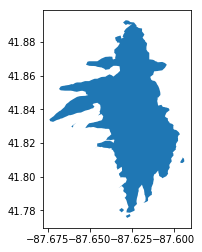

In [36]:
# view the resulting isochrone shape (can you guess why there are separated geographies?)
iso_gdf.plot();

One potential use case for this functionality: can people at two locations reach some common location within a specified travel time?

In [37]:
# 2nd location
start_point_2 = [41.884260, -87.630344] # Traffic Court in Richard J. Daley center

url_2 = ("{}isochrone?fromPlace={},{}&mode={}&date=2016-06-01&cutoffSec={}").format(
    base_url,start_point_2[0],start_point[1],mode,travel_time)

# get json request
iso_json_2 = json.loads(requests.get(url_2).text)

## load isochrone into a geopandas dataframe
iso_gdf_2 = gpd.GeoDataFrame.from_features(iso_json_2['features'])

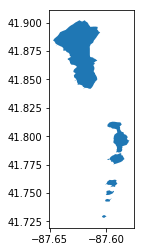

In [38]:
# view the second isochrone
iso_gdf_2.plot();

In [39]:
# do the two isochrones intersect?
iso_gdf.intersects(iso_gdf_2)

0    True
dtype: bool

In [40]:
# they do intersect, so create an overlay with a 'union'
iso_join = gpd.overlay(iso_gdf, iso_gdf_2, how='union')

Self-intersection at or near point -87.647800000000004 41.819699999999997


In [41]:
# what does the dataframe look like now?
iso_join.head()

,time,time_2,geometry
0,NaN,1800.0,"POLYGON ((-87.60339999999999 41.7286, -87.604 ..."
1,NaN,1800.0,"POLYGON ((-87.6011 41.7428, -87.601 41.744, -8..."
2,NaN,1800.0,"POLYGON ((-87.6006 41.7486, -87.5998 41.7494, ..."
3,NaN,1800.0,"POLYGON ((-87.60120000000001 41.7572, -87.5999..."
4,1800.0,1800.0,"POLYGON ((-87.596 41.8081, -87.59610000000001 ..."


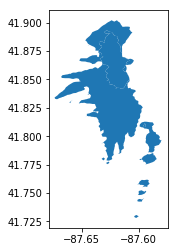

In [42]:
# and visually?
iso_join.plot();

- Back to the [Table of Contents](#Table-of-Contents)

> A bit annoyingly this is difficult to tell where the two overlap. To fix this we can group based on the "time" and "time_2" columns to end with just 3 combinations: 
1. accessible from our first location only, 
2. accessible our second location only, and 
3. accessible from either location

We'll do this by using the ["dissolve" function](http://geopandas.org/aggregation_with_dissolve.html) from geopandas. However first we need to replace the "NaN" so those rows are not ignored

In [43]:
# replace NaN with placeholder value, let's say 99999
iso_join.fillna(99999, inplace=True)

In [44]:
iso_join = iso_join.dissolve(by=['time', 'time_2']).reset_index()

# Note: used reset_index() here so it's easier to use the 'time' and 'time_2' columns if needed

In [45]:
# now what does it look like?
iso_join

,time,time_2,geometry
0,1800.0,1800.0,"(POLYGON ((-87.596 41.8081, -87.59610000000001..."
1,1800.0,99999.0,"(POLYGON ((-87.62779999999999 41.7754, -87.628..."
2,99999.0,1800.0,"(POLYGON ((-87.60339999999999 41.7286, -87.604..."


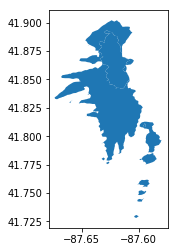

In [46]:
# and visually?
iso_join.plot();

In [47]:
# add a label column to use so we can include a legend
iso_join['label'] = ''

# use index slicing function '.loc' of dataframes to update each value of label appropriately
iso_join.loc[0,'label'] = 'Both'
iso_join.loc[1,'label'] = 'point 1 only'
iso_join.loc[2,'label'] = 'point 2 only'

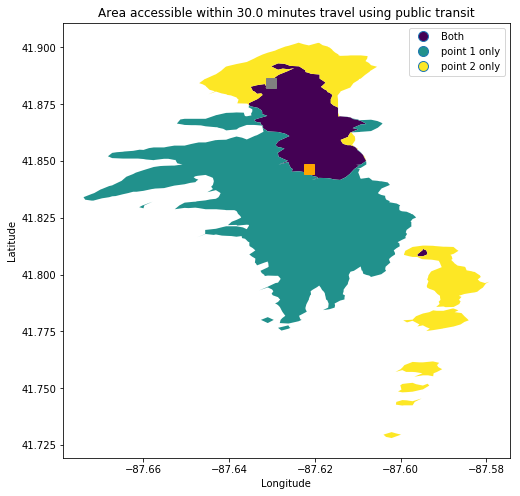

In [48]:
# set up a nicer visualization with labels
f,ax = plt.subplots(figsize=(8,8))

# use geopandas to specify label column and adding a legend to the matplotlib object 'ax'
iso_join.plot(column='label', ax=ax, legend=True, cmap='viridis');

# also plot start and stop points on the same map, note matplotlib takes [x,y] coordinates
ax.plot(start_point[1], start_point[0], 's', color='orange', markersize=10, label='point 1')
ax.plot(start_point_2[1], start_point_2[0], 's', color='grey', markersize=10, label='point 2')

# add some other labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# title
ax.set_title('Area accessible within {} minutes travel using public transit'.format(travel_time/60));